(3, 10, 4, 5)
(3, 10, 4)


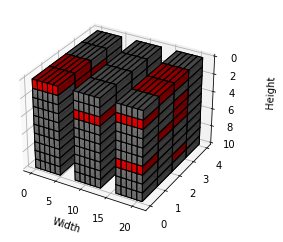

(3, 10, 4, 5)
(3, 10)


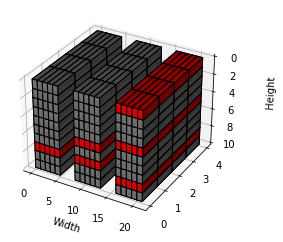

(3, 10, 4, 5)
(3,)


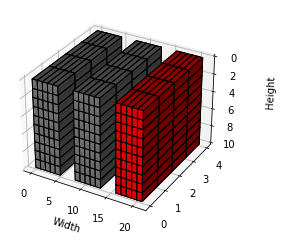

(3, 10, 4, 5)
(3, 10)


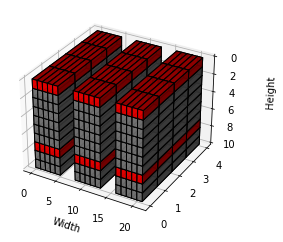

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def visualize_tensor(tensor, batch_spacing =3):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for batch in range(tensor.shape[0]):
        for channel in range(tensor.shape[1]):
            for i in range(tensor.shape[2]): # height
                for j in range(tensor.shape[3]): # width
                    x, y, z = j + (batch * (tensor.shape[3] + batch_spacing)), i, channel
                    color = 'red' if tensor[batch, channel, i, j] == 0 else 'gray'
                    ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=color, edgecolor='black', alpha=0.9)
    
    ax.set_xlabel('Width')
    ax.set_zlabel('Height')
    ax.set_zlim(ax.get_zlim()[::-1])
    ax.zaxis.labelpad = 15 # adjust z-axis label position

    plt.show()


def prune_conv_layer(conv_layer, prune_method, percentile=20, vis=True):
    pruned_layer = conv_layer.copy()

    # Prune by percentile
    if prune_method == "fine_grained":
        pruned_layer[np.abs(pruned_layer) < 0.05] = 0


    if prune_method == "vector_level":
        # compute the l2 sum along the last dimension (w)
        # 沿着最后一个维度 col 计算 l2 sum
        l2_sum = np.linalg.norm(pruned_layer, axis=-1)
    
    if prune_method == "kernel_level":
        # compute the l2 sum of each kernel (w, h)
        l2_sum = np.linalg.norm(pruned_layer, axis=(-2, -1))


    if prune_method == "filter_level":
        # compute the l2 sum of each filter (w, h, c)
        l2_sum = np.sum(pruned_layer**2, axis=(-3, -2, -1))

    if prune_method == "channel_level":
        # compute the l2 sum of each channel (w, h, c)
        l2_sum = np.sum(pruned_layer**2, axis=(-4, -2, -1))
        # add a new dimension at the front
        l2_sum = l2_sum.reshape(1, -1) # equivalent to l2_sum.reshape(1,3)

        # repeat the new dimension 8 times
        l2_sum = np.repeat(l2_sum, pruned_layer.shape[0], axis= 0)

    # find the threshold value corresponding to the bottom 0.1
    threshold = np.percentile(l2_sum, percentile)

    # create a mask for rows with an L2 sum less than the threshold
    mask = l2_sum < threshold

    print(pruned_layer.shape)
    print(mask.shape)
    print("==============================")
    pruned_layer[mask] = 0

    if vis:
        visualize_tensor(pruned_layer)
    return pruned_layer


if __name__ == '__main__':
    tensor = np.random.uniform(low = -1, high = 1, size=(3, 10, 4, 5))
    pruned_tensor = prune_conv_layer(tensor, "vector_level", vis=True)
    pruned_tensor = prune_conv_layer(tensor, "kernel_level", vis=True)
    pruned_tensor = prune_conv_layer(tensor, "filter_level", vis=True)
    pruned_tensor = prune_conv_layer(tensor, "channel_level", vis=True)

